# Práctica MLOps: Versionado de Modelos con MLflow y Git

Este cuaderno demuestra un flujo de trabajo práctico para gestionar diferentes versiones de un modelo de machine learning utilizando MLflow para el seguimiento de experimentos y el registro de modelos, y GitHub para la persistencia del código y los artefactos.

**Resumen del Flujo de Trabajo:**
1.  **Configuración:** Instalar e importar las librerías necesarias.
2.  **Inicialización:** Clonar un repositorio base y configurar el seguimiento local de MLflow.
3.  **Carga del Modelo Inicial:** Cargar un modelo de análisis de sentimiento preexistente.
4.  **Evaluación del Modelo Inicial:** Evaluar el rendimiento del modelo inicial con datos nuevos para detectar posible degradación (drift).
5.  **Reentrenamiento del Modelo:** Reentrenar el modelo utilizando los datos nuevos si la evaluación anterior lo justifica.
6.  **Evaluación del Modelo Reentrenado:** Evaluar el rendimiento del modelo recién entrenado.
7.  **Versionado con MLflow:** Registrar el modelo reentrenado en MLflow como una nueva versión.
8.  **Persistencia de Cambios:** Confirmar los cambios (incluyendo metadatos de MLflow) y enviarlos (push) a un repositorio de GitHub.

## 1. Configuración: Instalar e Importar Librerías

Primero, instalamos los paquetes Python requeridos con versiones específicas para asegurar la reproducibilidad. Luego, importamos todos los módulos necesarios.

In [2]:
# Instalar librerías requeridas con versiones específicas (modo silencioso -q)
!pip install scikit-learn==1.3.1 pandas numpy==1.26.4 nltk==3.9.1 seaborn==0.13.2 xgboost mlflow==2.19.0 flask pyngrok joblib -q

# Importar librerías
import pandas as pd
import numpy as np
import re
import nltk
import os
import joblib # Para cargar/guardar modelos y funciones
import subprocess # Para ejecutar comandos de shell (ej. SSH)
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from xgboost import XGBClassifier

import mlflow
from google.colab import drive # Para acceder a Drive (ej., para claves SSH)

import warnings
warnings.filterwarnings('ignore') # Ignorar advertencias para una salida más limpia

# Descargar datos necesarios de NLTK (stopwords y tokenizador punkt)
print("Descargando datos de NLTK...")
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)
print("Datos de NLTK listos.")

Descargando datos de NLTK...
Datos de NLTK listos.


## 2. Inicialización: Repositorio y Configuración de MLflow

Clonaremos un repositorio base que contiene nuestro modelo inicial y los datos. A continuación, configuraremos MLflow para rastrear experimentos y modelos localmente dentro de la estructura de este repositorio.

In [3]:
# --- Configuración de Rutas y Repositorio ---
# URL del repositorio original (solo para la clonación inicial)
GITHUB_REPO_URL_ORIGINAL = "https://github.com/prof-apartida/Practica.git"
# Ruta local donde se clonará y trabajará
RUTA_REPOSITORIO_LOCAL = "/content/Practica_MLOps"
# Directorio para el seguimiento de MLflow dentro del repo local
DIRECTORIO_TRACKING_MLFLOW = os.path.join(RUTA_REPOSITORIO_LOCAL, "mlflow")
# Directorio donde se encuentran los modelos iniciales
DIRECTORIO_MODELOS_INICIALES = os.path.join(RUTA_REPOSITORIO_LOCAL, "modelos")
# Directorio donde se encuentran los datasets
DIRECTORIO_DATASETS = os.path.join(RUTA_REPOSITORIO_LOCAL, "datasets")

# Clonar el repositorio original
if os.path.exists(RUTA_REPOSITORIO_LOCAL):
    print(f"Eliminando directorio existente: {RUTA_REPOSITORIO_LOCAL}")
    !rm -rf {RUTA_REPOSITORIO_LOCAL}
print(f"Clonando repositorio desde {GITHUB_REPO_URL_ORIGINAL}...")
!git clone {GITHUB_REPO_URL_ORIGINAL} {RUTA_REPOSITORIO_LOCAL}

# Configurar URI de seguimiento de MLflow y experimento
os.makedirs(DIRECTORIO_TRACKING_MLFLOW, exist_ok=True)
# Asegurar que la URI usa el path absoluto
MLFLOW_TRACKING_URI = f'file:{os.path.abspath(DIRECTORIO_TRACKING_MLFLOW)}'
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"MLflow tracking URI set to: {MLFLOW_TRACKING_URI}")

# Nombre descriptivo para el experimento de MLflow
NOMBRE_EXPERIMENTO = "Versionado_Analisis_Sentimiento"
experiment = mlflow.get_experiment_by_name(NOMBRE_EXPERIMENTO)
if experiment is None:
    experiment_id = mlflow.create_experiment(NOMBRE_EXPERIMENTO)
    print(f"Creado nuevo experimento MLflow '{NOMBRE_EXPERIMENTO}' con ID: {experiment_id}")
else:
    experiment_id = experiment.experiment_id
    print(f"Usando experimento MLflow existente '{NOMBRE_EXPERIMENTO}' con ID: {experiment_id}")

mlflow.set_experiment(NOMBRE_EXPERIMENTO)

Clonando repositorio desde https://github.com/prof-apartida/Practica.git...
Cloning into '/content/Practica_MLOps'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 342 (delta 0), reused 0 (delta 0), pack-reused 341 (from 1)
Receiving objects: 100% (342/342), 3.56 MiB | 21.97 MiB/s, done.
Resolving deltas: 100% (133/133), done.
MLflow tracking URI set to: file:/content/Practica_MLOps/mlflow
Creado nuevo experimento MLflow 'Versionado_Analisis_Sentimiento' con ID: 686083996175465282


<Experiment: artifact_location='file:///content/Practica_MLOps/mlflow/686083996175465282', creation_time=1743365853047, experiment_id='686083996175465282', last_update_time=1743365853047, lifecycle_stage='active', name='Versionado_Analisis_Sentimiento', tags={}>

## 3. Carga del Modelo Inicial y Definición de Utilidades

Cargamos el pipeline inicial de análisis de sentimiento desde su archivo `.joblib`. También definimos las funciones necesarias para el preprocesamiento del texto y la evaluación del modelo.

In [4]:
# Definir rutas para el modelo inicial y los datos nuevos
RUTA_PIPELINE_INICIAL = os.path.join(DIRECTORIO_MODELOS_INICIALES, 'sentiment_analysis_pipeline.joblib')
RUTA_DATOS_NUEVOS = os.path.join(DIRECTORIO_DATASETS, 'Apple-Twitter-Sentiment_new.csv')
RUTA_FUNCION_PREPROCESO = os.path.join(DIRECTORIO_MODELOS_INICIALES, 'preprocess_text_function.joblib')

# --- Función de Preprocesamiento de Texto ---
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def preprocess_text(text):
    """Preprocesamiento básico de texto: minúsculas, eliminar URLs/menciones/hashtags/palabras específicas, quitar caracteres especiales, stemming."""
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    # Eliminar URLs, menciones, hashtags y palabras de ruido específicas
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\s*(apple|aapl|appl|rt|amp)\s*', ' ', text) # Reemplazar con espacio
    # Eliminar caracteres especiales (manteniendo puntuación básica)
    text = re.sub(r'[^a-z\s.,!?]', '', text)
    # Stemming
    stemmer = PorterStemmer()
    words = text.split()
    # Eliminar stopwords antes del stemming
    stop_words_set = set(stopwords.words('english'))
    words = [stemmer.stem(word) for word in words if word not in stop_words_set]
    return ' '.join(words)

# Guardar la función de preprocesamiento (opcional, pero buena práctica)
os.makedirs(DIRECTORIO_MODELOS_INICIALES, exist_ok=True) # Asegurar que el directorio existe
joblib.dump(preprocess_text, RUTA_FUNCION_PREPROCESO)
print(f"Función de preprocesamiento guardada en {RUTA_FUNCION_PREPROCESO}")

# --- Mapeo de Etiquetas ---
# Convertir etiquetas de sentimiento (-1, 0, 1) a clases numéricas (0, 1, 2) para XGBoost
label_mapping = {-1.0: 0, 0.0: 1, 1.0: 2}
label_names = ['Negativo', 'Neutral', 'Positivo'] # Para gráficos

# --- Utilidades de Evaluación ---
def plot_confusion_matrix(y_true, y_pred, class_labels, title):
    """Grafica una matriz de confusión usando seaborn."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title)
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

def evaluate_model(y_true, y_pred, y_prob, class_labels_names, title):
    """Evalúa el modelo, imprime métricas y grafica la matriz de confusión."""
    print(f"\n=== Evaluación del Modelo: {title} ===")
    print("\nMatriz de Confusión:")
    # Asegurar que las etiquetas numéricas coincidan con los nombres para el gráfico
    numeric_labels = sorted(y_true.unique())
    plot_confusion_matrix(y_true, y_pred, class_labels_names, title)

    print("\nInforme de Clasificación:")
    print(classification_report(y_true, y_pred, target_names=class_labels_names))

    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy Score: {accuracy:.4f}")

    # Calcular ROC AUC (One-vs-Rest para multiclase)
    auc_ovr = None # Inicializar
    if y_prob is not None and hasattr(y_prob, 'shape') and y_prob.shape[1] == len(class_labels_names):
        try:
            auc_ovr = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
            print(f"Macro Average ROC AUC (OvR): {auc_ovr:.4f}")
        except ValueError as e:
            print(f"No se pudo calcular ROC AUC: {e}")
    else:
        print("No se proporcionaron probabilidades válidas para ROC AUC.")

    # Registrar métricas en MLflow si estamos dentro de una ejecución activa
    if mlflow.active_run():
        # Crear un prefijo para las métricas basado en el título (ej. 'initial_model_new_data_')
        metric_prefix = title.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('__','_') + "_"
        mlflow.log_metric(f"{metric_prefix}accuracy", accuracy)
        if auc_ovr is not None:
            mlflow.log_metric(f"{metric_prefix}roc_auc_ovr", auc_ovr)
        print(f"Métricas registradas en MLflow para '{title}'.")


# --- Carga del Modelo Inicial ---
print(f"Cargando pipeline inicial desde {RUTA_PIPELINE_INICIAL}...")
try:
    initial_pipeline = joblib.load(RUTA_PIPELINE_INICIAL)
    print(f"Pipeline inicial cargado exitosamente.")
except FileNotFoundError:
    print(f"Error: Archivo del pipeline inicial no encontrado en {RUTA_PIPELINE_INICIAL}")
    initial_pipeline = None # Manejar el error apropiadamente en pasos siguientes
except Exception as e:
    print(f"Error al cargar el pipeline inicial: {e}")
    initial_pipeline = None

Función de preprocesamiento guardada en /content/Practica_MLOps/modelos/preprocess_text_function.joblib
Cargando pipeline inicial desde /content/Practica_MLOps/modelos/sentiment_analysis_pipeline.joblib...
Pipeline inicial cargado exitosamente.


## 4. Evaluación del Modelo Inicial con Datos Nuevos

Ahora cargamos un nuevo conjunto de datos (simulando datos entrantes) y evaluamos el rendimiento de nuestro modelo *inicial* cargado sobre ellos. Esto ayuda a determinar si el rendimiento del modelo se ha degradado (drift) y si es necesario reentrenar.

Cargando datos nuevos desde /content/Practica_MLOps/datasets/Apple-Twitter-Sentiment_new.csv...
Cargadas 5946 filas.
Preprocesando datos nuevos...
Evaluando modelo inicial con datos nuevos...

=== Evaluación del Modelo: Modelo Inicial (Datos Nuevos) ===

Matriz de Confusión:


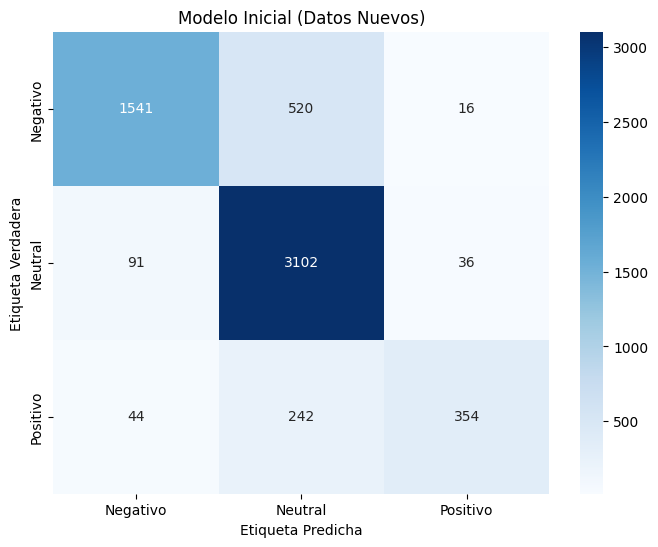


Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.92      0.74      0.82      2077
     Neutral       0.80      0.96      0.87      3229
    Positivo       0.87      0.55      0.68       640

    accuracy                           0.84      5946
   macro avg       0.86      0.75      0.79      5946
weighted avg       0.85      0.84      0.83      5946


Accuracy Score: 0.8404
Macro Average ROC AUC (OvR): 0.9385


In [5]:
# Cargar el nuevo dataset
print(f"Cargando datos nuevos desde {RUTA_DATOS_NUEVOS}...")
try:
    df_new = pd.read_csv(RUTA_DATOS_NUEVOS, sep=',', encoding='latin-1', on_bad_lines='warn')
    print(f"Cargadas {len(df_new)} filas.")
except FileNotFoundError:
    print(f"Error: Archivo de datos nuevos no encontrado en {RUTA_DATOS_NUEVOS}")
    df_new = pd.DataFrame() # Asignar DataFrame vacío para evitar errores posteriores

if not df_new.empty and initial_pipeline is not None:
    # Preprocesar los datos nuevos
    print("Preprocesando datos nuevos...")
    df_new['processed_text'] = df_new['tweets'].apply(preprocess_text)
    df_new['labels'] = df_new['labels'].map(label_mapping)
    df_new_valid = df_new.dropna(subset=['labels', 'processed_text'])
    # Asegurarse de que las etiquetas son enteros
    df_new_valid['labels'] = df_new_valid['labels'].astype(int)

    X_new = df_new_valid # Features para la predicción (el pipeline usará 'processed_text')
    y_new_true = df_new_valid['labels'] # Etiquetas verdaderas

    # Predecir usando el modelo inicial
    print("Evaluando modelo inicial con datos nuevos...")
    y_new_pred = initial_pipeline.predict(X_new)

    # Intentar obtener probabilidades para ROC AUC
    y_new_proba = None
    if hasattr(initial_pipeline, "predict_proba"):
        try:
            y_new_proba = initial_pipeline.predict_proba(X_new)
        except Exception as e:
            print(f"Error al obtener probabilidades: {e}")
    else:
         print("El pipeline inicial no tiene el método predict_proba.")

    # Evaluar
    evaluate_model(y_new_true, y_new_pred, y_new_proba, label_names, "Modelo Inicial (Datos Nuevos)")

else:
    print("Saltando evaluación del modelo inicial debido a falta de datos o archivo del modelo.")

## 5. Reentrenamiento del Modelo

Basándonos en la evaluación anterior (o como parte de un proceso de reentrenamiento programado), procedemos a reentrenar el modelo utilizando el conjunto de datos más reciente.

In [6]:
# --- Preparación de Datos para Reentrenamiento ---
if not df_new.empty:
    print("Preparando datos para el reentrenamiento...")
    # Usaremos df_new_valid que ya tiene texto procesado y etiquetas mapeadas
    X = df_new_valid # Contiene 'processed_text' y otras columnas originales
    y = df_new_valid['labels']

    # Dividir en conjuntos de entrenamiento y prueba (para evaluar el modelo reentrenado)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"Datos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")

    # --- Definición del Pipeline de Reentrenamiento ---
    # Crear el transformador de características (TF-IDF sobre texto procesado)
    # Usamos `remainder='drop'` para usar solo la columna transformada
    tfidf_transformer = make_column_transformer(
        (TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=1000), 'processed_text'),
        remainder='drop'
    )

    # Definir el clasificador XGBoost con hiperparámetros
    xgb_classifier = XGBClassifier(
        random_state=42,
        n_estimators=300,
        max_depth=3,
        learning_rate=0.3,
        subsample=1.0,
        colsample_bytree=0.8,
        gamma=0.2,
        objective='multi:softprob', # Para clasificación multiclase con probabilidades
        eval_metric='mlogloss' # Métrica común para multiclase
    )

    # Crear el pipeline completo: preprocesamiento + clasificación
    retrained_pipeline = Pipeline([
        ('preprocessor', tfidf_transformer),
        ('classifier', xgb_classifier)
    ])

    # --- Reentrenamiento ---
    print("Iniciando reentrenamiento del pipeline...")
    try:
        retrained_pipeline.fit(X_train, y_train)
        print("Reentrenamiento completado.")
        MODELO_REENTRENADO_DISPONIBLE = True
    except Exception as e:
        print(f"Error durante el reentrenamiento: {e}")
        MODELO_REENTRENADO_DISPONIBLE = False
else:
    print("No hay datos nuevos disponibles para reentrenar.")
    MODELO_REENTRENADO_DISPONIBLE = False

Preparando datos para el reentrenamiento...
Datos divididos: 4756 para entrenamiento, 1190 para prueba.
Iniciando reentrenamiento del pipeline...
Reentrenamiento completado.


## 6. Evaluación del Modelo Reentrenado

Evaluamos el modelo recién reentrenado tanto en el conjunto de entrenamiento como en el de prueba para verificar su rendimiento y detectar posible sobreajuste (overfitting).

Evaluando el modelo reentrenado...
--- Evaluación en Conjunto de Entrenamiento ---

=== Evaluación del Modelo: Modelo Reentrenado (Entrenamiento) ===

Matriz de Confusión:


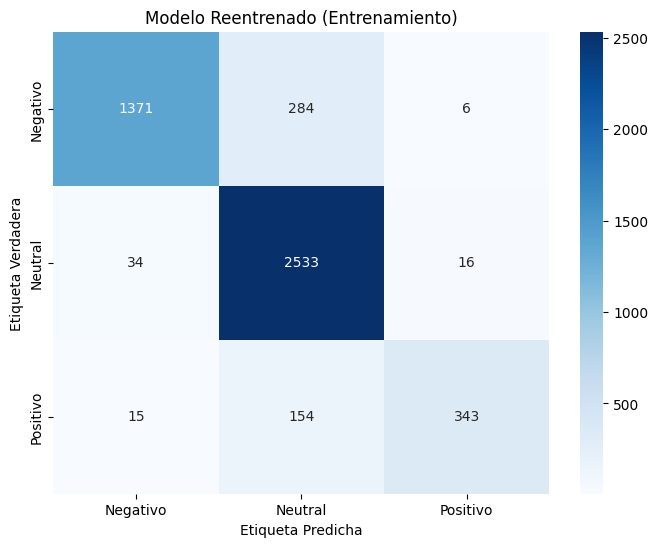


Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.97      0.83      0.89      1661
     Neutral       0.85      0.98      0.91      2583
    Positivo       0.94      0.67      0.78       512

    accuracy                           0.89      4756
   macro avg       0.92      0.83      0.86      4756
weighted avg       0.90      0.89      0.89      4756


Accuracy Score: 0.8930
Macro Average ROC AUC (OvR): 0.9732

--- Evaluación en Conjunto de Prueba ---

=== Evaluación del Modelo: Modelo Reentrenado (Prueba) ===

Matriz de Confusión:


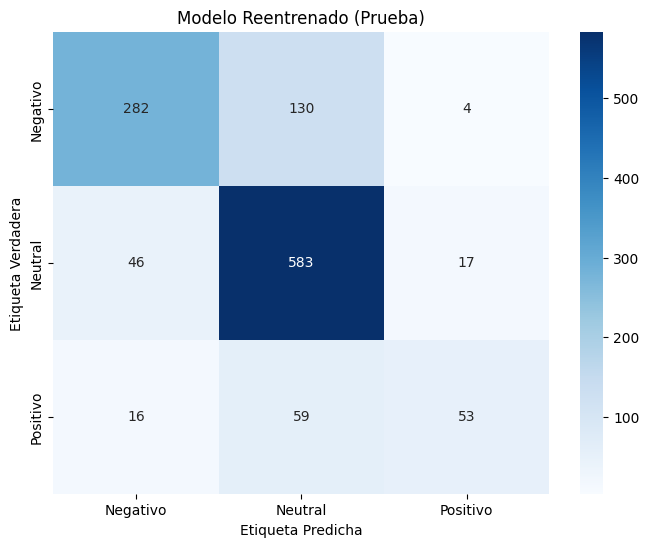


Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.82      0.68      0.74       416
     Neutral       0.76      0.90      0.82       646
    Positivo       0.72      0.41      0.52       128

    accuracy                           0.77      1190
   macro avg       0.76      0.66      0.70      1190
weighted avg       0.77      0.77      0.76      1190


Accuracy Score: 0.7714
Macro Average ROC AUC (OvR): 0.8642


In [7]:
if MODELO_REENTRENADO_DISPONIBLE:
    print("Evaluando el modelo reentrenado...")

    # Evaluar en el conjunto de entrenamiento
    print("--- Evaluación en Conjunto de Entrenamiento ---")
    y_train_pred = retrained_pipeline.predict(X_train)
    y_train_proba = retrained_pipeline.predict_proba(X_train)
    evaluate_model(y_train, y_train_pred, y_train_proba, label_names, "Modelo Reentrenado (Entrenamiento)")

    # Evaluar en el conjunto de prueba
    print("\n--- Evaluación en Conjunto de Prueba ---")
    y_test_pred = retrained_pipeline.predict(X_test)
    y_test_proba = retrained_pipeline.predict_proba(X_test)
    evaluate_model(y_test, y_test_pred, y_test_proba, label_names, "Modelo Reentrenado (Prueba)")

else:
    print("Saltando evaluación del modelo reentrenado.")

## 7. Versionado con MLflow

Si el modelo reentrenado muestra un rendimiento satisfactorio (idealmente, mejor que el modelo inicial en los datos nuevos), lo registramos en MLflow. Utilizamos el **Registro de Modelos de MLflow** para asignar un nombre al modelo y crear automáticamente una nueva versión.

Registrando el modelo reentrenado en MLflow como 'Pipeline_Analisis_Sentimiento'...

=== Evaluación del Modelo: Modelo Reentrenado (Prueba) ===

Matriz de Confusión:


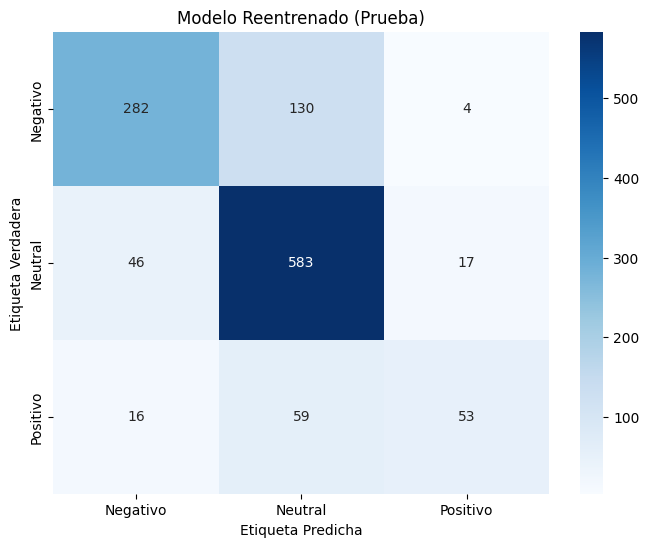


Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.82      0.68      0.74       416
     Neutral       0.76      0.90      0.82       646
    Positivo       0.72      0.41      0.52       128

    accuracy                           0.77      1190
   macro avg       0.76      0.66      0.70      1190
weighted avg       0.77      0.77      0.76      1190


Accuracy Score: 0.7714
Macro Average ROC AUC (OvR): 0.8642
Métricas registradas en MLflow para 'Modelo Reentrenado (Prueba)'.


2025/03/30 20:22:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado exitosamente en MLflow.
Run ID: 68e58047fec845e6ae5132548ad80126
Ver el modelo registrado: 'Pipeline_Analisis_Sentimiento'


Successfully registered model 'Pipeline_Analisis_Sentimiento'.
Created version '1' of model 'Pipeline_Analisis_Sentimiento'.


In [9]:
# Nombre para registrar el modelo en MLflow
NOMBRE_MODELO_REGISTRADO = "Pipeline_Analisis_Sentimiento"

if MODELO_REENTRENADO_DISPONIBLE:
    print(f"Registrando el modelo reentrenado en MLflow como '{NOMBRE_MODELO_REGISTRADO}'...")
    # Iniciar una ejecución de MLflow para registrar el modelo y sus métricas
    with mlflow.start_run(experiment_id=experiment_id, run_name="Reentrenamiento_Modelo_Sentimiento") as run:
        # Registrar parámetros (opcional, pero útil)
        # Get parameters of the classifier from the pipeline
        classifier_params = retrained_pipeline.named_steps['classifier'].get_params()
        # Now log the parameters as a dictionary
        mlflow.log_params(classifier_params)  # Log XGBoost params

        # Evaluar y registrar métricas de prueba dentro de la ejecución
        evaluate_model(y_test, y_test_pred, y_test_proba, label_names, "Modelo Reentrenado (Prueba)")

        # Registrar el modelo en el registro de modelos de MLflow
        # Esto crea automáticamente una nueva versión si el nombre ya existe
        mlflow.sklearn.log_model(
            sk_model=retrained_pipeline,
            artifact_path="modelo_sentimiento", # Ruta dentro de los artefactos de la ejecución
            registered_model_name=NOMBRE_MODELO_REGISTRADO # Nombre en el registro
        )

        run_id = run.info.run_id
        print(f"Modelo registrado exitosamente en MLflow.")
        print(f"Run ID: {run_id}")
        print(f"Ver el modelo registrado: '{NOMBRE_MODELO_REGISTRADO}'")

else:
    print("No se registró ningún modelo nuevo en MLflow.")

## 8. Persistencia de Cambios en GitHub

Finalmente, guardamos todos los cambios realizados en nuestro repositorio local (incluyendo los nuevos archivos y directorios generados por MLflow para el seguimiento) en nuestro repositorio remoto de GitHub. Esto asegura que tanto el código como el historial de experimentos y modelos estén versionados y respaldados.

**¡Importante!**
1.  **Configuración SSH:** Necesitas tener una clave SSH configurada en tu Google Drive y registrada en tu cuenta de GitHub para que los comandos `git push` funcionen.
2.  **URL del Repositorio:** Debes reemplazar `tu_usuario_o_organizacion/tu_repositorio.git` con la URL SSH de tu propio repositorio en GitHub donde quieras guardar esta práctica.

In [13]:
# --- Configuración de Git y SSH ---
# Montar Google Drive para acceder a la clave SSH
try:
    drive.mount('/content/drive')
    SSH_KEY_PATH = '/content/drive/MyDrive/id_rsa' # Ajusta esta ruta si tu clave está en otro lugar
    if not os.path.exists(SSH_KEY_PATH):
        print(f"ADVERTENCIA: No se encontró la clave SSH en {SSH_KEY_PATH}. El push a GitHub fallará.")
        SSH_CONFIGURADO = False
    else:
        print("Google Drive montado. Clave SSH localizada.")
        SSH_CONFIGURADO = True
except Exception as e:
    print(f"Error al montar Google Drive: {e}. El push a GitHub fallará.")
    SSH_CONFIGURADO = False

if SSH_CONFIGURADO:
    # Configurar el agente SSH para usar la clave privada
    print("Configurando agente SSH...")
    os.makedirs(os.path.expanduser('~/.ssh'), exist_ok=True)
    known_hosts_path = os.path.expanduser('~/.ssh/known_hosts')
    if not os.path.exists(known_hosts_path):
        open(known_hosts_path, 'a').close()
    # Añadir la clave de host de GitHub si no está
    !ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

    # Start the SSH agent
    process = subprocess.Popen(['ssh-agent'], stdout=subprocess.PIPE)
    output, _ = process.communicate()

    # Set environment variables for the current session
    for line in output.decode().strip().split('\n'):
        if 'SSH_AUTH_SOCK' in line or 'SSH_AGENT_PID' in line:
            key, value = line.split(';')[0].strip().split('=')
            os.environ[key] = value
    try:
        print(f"Añadiendo clave SSH: {SSH_KEY_PATH}")
        subprocess.run(['ssh-add', SSH_KEY_PATH], check=True, capture_output=True, text=True)
        print("Clave SSH añadida al agente.")
    except subprocess.CalledProcessError as e:
        print(f"Error añadiendo clave SSH: {e.stderr}")
        SSH_CONFIGURADO = False # Marcar como no configurado si falla
    except FileNotFoundError:
        print("Error: ssh-add no encontrado. Asegúrate de que OpenSSH está disponible.")
        SSH_CONFIGURADO = False

# --- Comandos Git para Persistir Cambios ---
if SSH_CONFIGURADO:
    print("\nPreparando para guardar cambios en GitHub...")
    %cd {RUTA_REPOSITORIO_LOCAL}

    # Configurar usuario de Git (reemplazar con tu información)
    GIT_USER_NAME = "fajillo77"
    GIT_USER_EMAIL = "fajillo@hotmail.com"
    !git config --global user.name "{GIT_USER_NAME}"
    !git config --global user.email "{GIT_USER_EMAIL}"

    # Añadir el repositorio remoto (reemplazar con tu URL SSH)
    # Ejemplo: git@github.com:tu_usuario/mi_practica_mlops.git
    GITHUB_REPO_SSH_URL = "git@github.com:fajillo77/actividad2-mlops.git"

    # Verificar si el remoto 'origin' ya existe y apunta a la URL correcta
    remote_check = subprocess.run(['git', 'remote', '-v'], capture_output=True, text=True)
    if GITHUB_REPO_SSH_URL not in remote_check.stdout:
        print("Configurando remoto 'origin'...")
        !git remote remove origin 2>/dev/null # Eliminar si existe
        !git remote add origin {GITHUB_REPO_SSH_URL}
    else:
        print("Remoto 'origin' ya configurado correctamente.")

    # Añadir, confirmar y empujar los cambios
    print("\nAñadiendo cambios al staging area...")
    !git add .
    print("\nRealizando commit...")
    # Usar una marca de tiempo en el mensaje de commit para diferenciar
    commit_message = f"Actualización de práctica MLOps - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    !git commit -m "{commit_message}"
    print("\nEmpujando cambios a GitHub (rama main)...")
    # Usar '-u' la primera vez para establecer upstream
    # Quitar '-f' (forzar) a menos que sepas que quieres sobrescribir el historial remoto
    !git push origin main

    print("\nProceso de Git completado.")
    %cd /content # Volver al directorio raíz de Colab
else:
    print("\nSaltando sincronización con GitHub debido a problemas de configuración SSH.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado. Clave SSH localizada.
Configurando agente SSH...
# github.com:22 SSH-2.0-7f7d2e999
Añadiendo clave SSH: /content/drive/MyDrive/id_rsa
Clave SSH añadida al agente.

Preparando para guardar cambios en GitHub...
/content/Practica_MLOps
Configurando remoto 'origin'...

Añadiendo cambios al staging area...

Realizando commit...
[main 803980c] Actualización de práctica MLOps - 2025-03-30 21:03:12
 60 files changed, 157 insertions(+)
 create mode 100644 mlflow/686083996175465282/68e58047fec845e6ae5132548ad80126/artifacts/modelo_sentimiento/MLmodel
 create mode 100644 mlflow/686083996175465282/68e58047fec845e6ae5132548ad80126/artifacts/modelo_sentimiento/conda.yaml
 create mode 100644 mlflow/686083996175465282/68e58047fec845e6ae5132548ad80126/artifacts/modelo_sentimiento/model.pkl
 create mode 100644 mlflow/686083996175465282/68e58047fec845e6ae5